In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm
from statsmodels import regression
from statsmodels.regression.rolling import RollingOLS
import pickle
from scipy.optimize import minimize

project_path = 'C:\\Users\\Administrator\\Desktop\\qf623\\project'

def read_clean_csv(filename, sr, nr, factor = True):
    df = pd.read_csv(os.path.join(project_path, 'data', filename), skiprows=sr, nrows=nr, parse_dates=True, index_col=0, 
                     date_parser=lambda x:pd.to_datetime(x, format='%Y%m'))
    df.index.name = 'Date'
    # set dates to month end as the returns refer to returns for the whole month
    df.index = df.index + pd.offsets.MonthEnd(0)
    if factor:
        if len(df.columns) == 6:
            df.columns = ['small_low', 'med_1', 'small_high', 'big_low', 'med_2', 'big_high']
        elif len(df.columns) == 25:
            df.columns = ['small_low', 'med1_2', 'med1_3', 'med1_4', 'small_high',
                          'med2_1', 'med2_2', 'med2_3', 'med2_4', 'med2_5',
                          'med3_1', 'med3_2', 'med3_3', 'med3_4', 'med3_5',
                          'med4_1', 'med4_2', 'med4_3', 'med4_4', 'med4_5',
                          'big_low', 'med5_2', 'med5_3', 'med5_4', 'big_high']
        elif len(df.columns) == 35:
            df.columns = ['small_neg', 'small_zero', 'small_low', 'med1_2', 'med1_3', 'med1_4', 'small_high',
                          'med2_neg', 'med2_zero', 'med2_low', 'med2_2', 'med2_3', 'med2_4', 'med2_high',
                          'med3_neg', 'med3_zero', 'med3_low', 'med3_2', 'med3_3', 'med3_4', 'med3_high',
                          'med4_neg', 'med4_zero', 'med4_low', 'med4_2', 'med4_3', 'med4_4', 'med4_high',
                          'big_neg', 'big_zero', 'big_low', 'med5_2', 'med5_3', 'med5_4', 'big_high']
    return df

In [2]:
## read data from csv. SKIP IF portfolios.p IS ALREADY LOADED 

portfolios = {}
ff_model = read_clean_csv('F-F_Research_Data_Factors.csv', sr=3, nr=1138, factor = False)

portfolios['book-to-market'] = {'value_weighted' : {'data' : read_clean_csv('6_Portfolios_2x3.csv', sr=15, nr=1138)},
                         'equal_weighted' : {'data' : read_clean_csv('6_Portfolios_2x3.csv', sr=1157, nr=1138)}}
portfolios['profitability'] = {'value_weighted' : {'data' : read_clean_csv('6_Portfolios_ME_OP_2x3.csv', sr=22, nr=694)},
                         'equal_weighted' : {'data' : read_clean_csv('6_Portfolios_ME_OP_2x3.csv', sr=720, nr=694)}}
portfolios['investment'] = {'value_weighted' : {'data' : read_clean_csv('6_Portfolios_ME_INV_2x3.csv', sr=16, nr=694)},
                         'equal_weighted' : {'data' : read_clean_csv('6_Portfolios_ME_INV_2x3.csv', sr=714, nr=694)}}
portfolios['earnings-yield'] = {'value_weighted' : {'data' : read_clean_csv('6_Portfolios_ME_EP_2x3.csv', sr=19, nr=838)},
                         'equal_weighted' : {'data' : read_clean_csv('6_Portfolios_ME_EP_2x3.csv', sr=861, nr=838)}}
portfolios['dividend-yield'] = {'value_weighted' : {'data' : read_clean_csv('6_Portfolios_ME_DP_2x3.csv', sr=19, nr=1126)},
                         'equal_weighted' : {'data' : read_clean_csv('6_Portfolios_ME_DP_2x3.csv', sr=1149, nr=1126)}}
portfolios['cashflow-to-price'] = {'value_weighted' : {'data' : read_clean_csv('6_Portfolios_ME_CFP_2x3.csv', sr=19, nr=838)},
                         'equal_weighted' : {'data' : read_clean_csv('6_Portfolios_ME_CFP_2x3.csv', sr=861, nr=838)}}
portfolios['12-1-price-momentum'] = {'value_weighted' : {'data' : read_clean_csv('6_Portfolios_ME_Prior_12_2.csv', sr=11, nr=1132)},
                         'equal_weighted' : {'data' : read_clean_csv('6_Portfolios_ME_Prior_12_2.csv', sr=1147, nr=1132)}}
portfolios['prior-1-month-return'] = {'value_weighted' : {'data' : read_clean_csv('6_Portfolios_ME_Prior_1_0.csv', sr=11, nr=1143)},
                         'equal_weighted' : {'data' : read_clean_csv('6_Portfolios_ME_Prior_1_0.csv', sr=1158, nr=1143)}}
portfolios['long-term-reversal'] = {'value_weighted' : {'data' : read_clean_csv('6_Portfolios_ME_Prior_60_13.csv', sr=11, nr=1084)},
                         'equal_weighted' : {'data' : read_clean_csv('6_Portfolios_ME_Prior_60_13.csv', sr=1099, nr=1084)}}
portfolios['accruals'] = {'value_weighted' : {'data' : read_clean_csv('25_Portfolios_ME_AC_5x5.csv', sr=18, nr=694)},
                         'equal_weighted' : {'data' : read_clean_csv('25_Portfolios_ME_AC_5x5.csv', sr=716, nr=694)}}
portfolios['beta'] = {'value_weighted' : {'data' : read_clean_csv('25_Portfolios_ME_BETA_5x5.csv', sr=16, nr=694)},
                         'equal_weighted' : {'data' : read_clean_csv('25_Portfolios_ME_BETA_5x5.csv', sr=714, nr=694)}}
portfolios['net-issuance'] = {'value_weighted' : {'data' : read_clean_csv('25_Portfolios_ME_NI_5x5.csv', sr=18, nr=694)},
                         'equal_weighted' : {'data' : read_clean_csv('25_Portfolios_ME_NI_5x5.csv', sr=716, nr=694)}}
portfolios['volatility'] = {'value_weighted' : {'data' : read_clean_csv('25_Portfolios_ME_VAR_5x5.csv', sr=19, nr=694)},
                         'equal_weighted' : {'data' : read_clean_csv('25_Portfolios_ME_VAR_5x5.csv', sr=717, nr=694)}}
portfolios['residual-volatility'] = {'value_weighted' : {'data' : read_clean_csv('25_Portfolios_ME_RESVAR_5x5.csv', sr=19, nr=694)},
                         'equal_weighted' : {'data' : read_clean_csv('25_Portfolios_ME_RESVAR_5x5.csv', sr=717, nr=694)}}

In [3]:
# =============================================================================
# PART 1
# =============================================================================

date_min = '1963-07-31'
qry = "index >= @date_min"

# merge rf column from ff_model dataframe into portfolios
for factor in portfolios.keys():
    for weight in portfolios[factor].keys():
        df = portfolios[factor][weight]['data'].copy()
        df_merged = pd.merge(df, ff_model, left_index = True, right_index = True)
        df_merged['small_low-RF'] = df_merged['small_low'] - df_merged['RF']
        df_merged['small_high-RF'] = df_merged['small_high'] - df_merged['RF']
        df_merged['big_low-RF'] = df_merged['big_low'] - df_merged['RF']
        df_merged['big_high-RF'] = df_merged['big_high'] - df_merged['RF']
        
        portfolios[factor][weight]['data'] = df_merged

        

In [4]:
def cum_ret(s):
    s = (s/100 + 1).cumprod() - 1
    return s


In [5]:
# calculate historical performance for long-short factor mimicking portfolios
for factor in portfolios.keys():
    for weight in portfolios[factor].keys():
        df = portfolios[factor][weight]['data'].copy()
        # typically go long (short) high (low) factor, except the following cases 
        if factor in ['investment', 
                      'net-issuance', 
                      'accruals', 
                      'beta', 
                      'volatility', 
                      'residual-volatility', 
                      'prior-1-month-return', 
                      'long-term-reversal']:
            df['small_ls_ret'] = df['small_low-RF'] - df['small_high-RF']
            df['big_ls_ret'] = df['big_low-RF'] - df['big_high-RF']
        else:
            df['small_ls_ret'] = df['small_high-RF'] - df['small_low-RF']
            df['big_ls_ret'] = df['big_high-RF'] - df['big_low-RF']
        df['mean_ls_ret'] = 0.5*df['small_ls_ret'] + 0.5*df['big_ls_ret']
        portfolios[factor][weight]['data'] = df


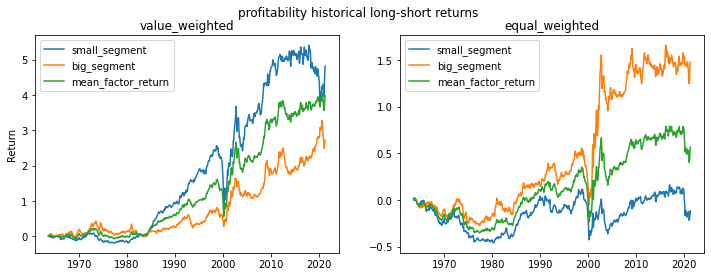

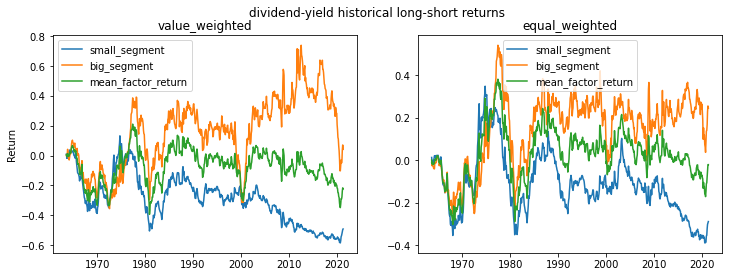

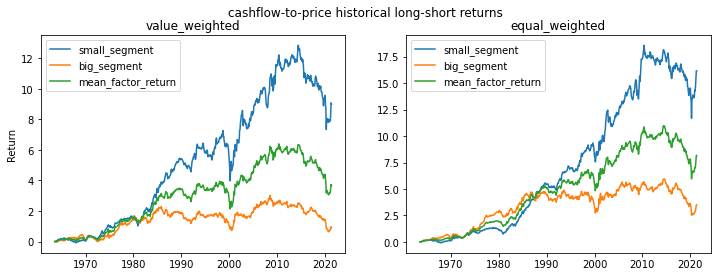

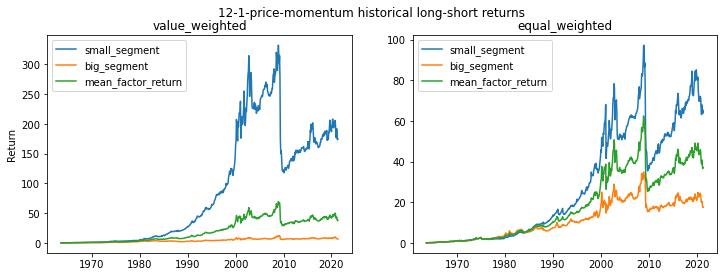

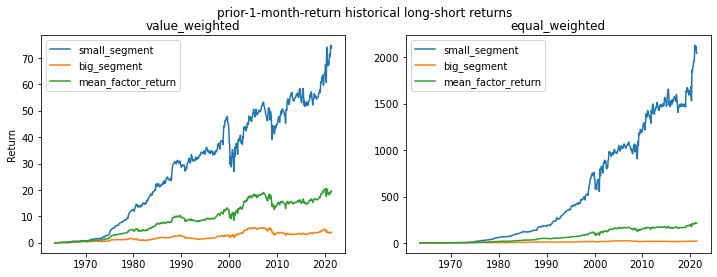

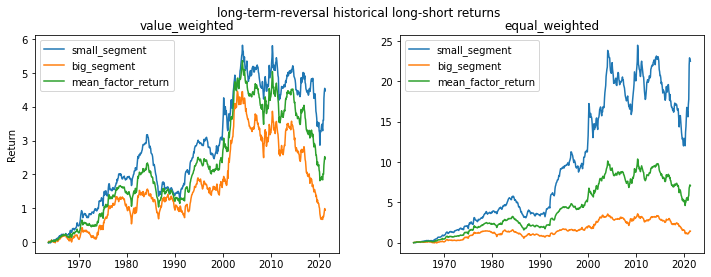

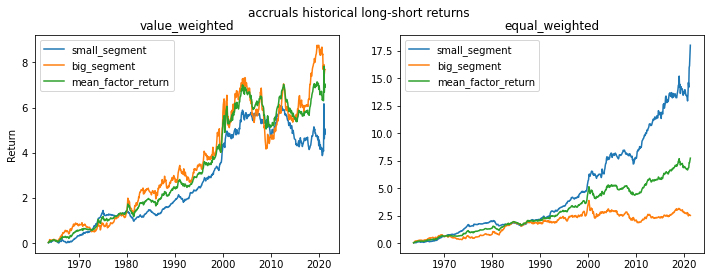

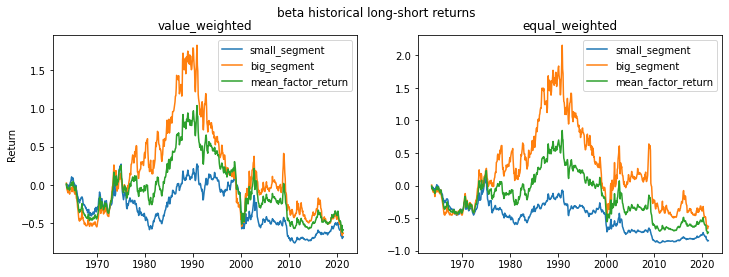

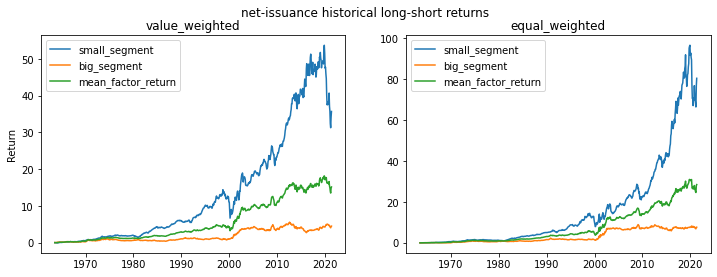

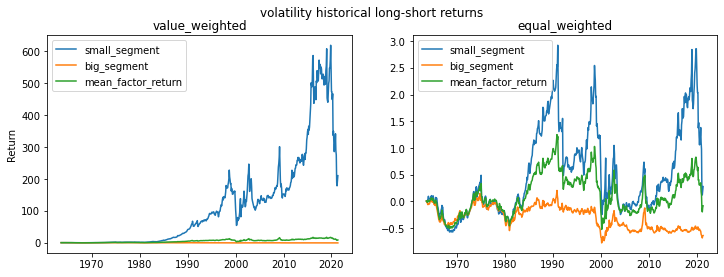

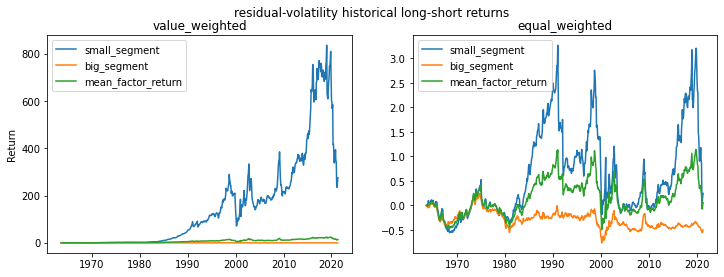

In [6]:
# plot historical returns 
for factor in portfolios.keys():
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (12,4))
    for i, weight in enumerate(portfolios[factor].keys()):
        df = portfolios[factor][weight]['data'].copy()
        df = df.query(qry)
        sns.lineplot(data = cum_ret(df['small_ls_ret']), ax = ax[i], label = 'small_segment')
        sns.lineplot(data = cum_ret(df['big_ls_ret']), ax = ax[i], label = 'big_segment')
        sns.lineplot(data = cum_ret(df['mean_ls_ret']), ax = ax[i], label = 'mean_factor_return')
#         sns.lineplot(data = cum_ret(ff_model.query(qry)['Mkt-RF']), ax = ax[i], label = 'market return')
        
        ax[i].set_xlabel('')
        ax[i].set_title(weight)
    ax[0].set_ylabel('Return')
    ax[1].set_ylabel('')
    fig.suptitle(factor + ' historical long-short returns')


In [7]:
# calculate rolling market beta
def rolling_linreg(x, y, window = 36):
    # recommended to manually add constant
    x = sm.add_constant(x)
    model = RollingOLS(endog = y, exog = x, window = window).fit()
    
    return model.params

y = ff_model.query(qry)['Mkt-RF'].values


In [8]:
for factor in portfolios.keys():
    for weight in portfolios[factor].keys():
        df = portfolios[factor][weight]['data'].copy()
        df = df.query(qry)
        idx = df.index
        df_model_params_ls = pd.DataFrame()
        df_model_params_factor = pd.DataFrame()
        
        for size in ['small', 'big']:
            # market beta of long-short portfolio
            x = df[size + '_ls_ret'].values
            
            df_tmp = pd.DataFrame(rolling_linreg(x,y))
            df_tmp.columns = ['alpha_ls_' + size, 'beta_ls_' + size]
            df_model_params_ls = pd.concat([df_model_params_ls, df_tmp], axis = 1)
            
            # market beta of individual factors
            x_low = df[size + '_low'].values
            x_high = df[size + '_high'].values
            
            df_tmp_low = pd.DataFrame(rolling_linreg(x_low,y))
            df_tmp_high = pd.DataFrame(rolling_linreg(x_high,y))
            df_tmp_low.columns = ['alpha_low_' + size, 'beta_low_' + size]
            df_tmp_high.columns = ['alpha_high_' + size, 'beta_high_' + size]
            df_tmp2 = pd.concat([df_tmp_low, df_tmp_high], axis = 1)
            df_model_params_factor = pd.concat([df_model_params_factor, df_tmp2], axis = 1)
        
        df_model_params_ls.index = idx
        df_combine = pd.concat([df, df_model_params_ls], axis = 1)
        df_model_params_factor.index = idx
        df_combine = pd.concat([df_combine, df_model_params_factor], axis = 1)
        
        portfolios[factor][weight]['returns_beta'] = df_combine


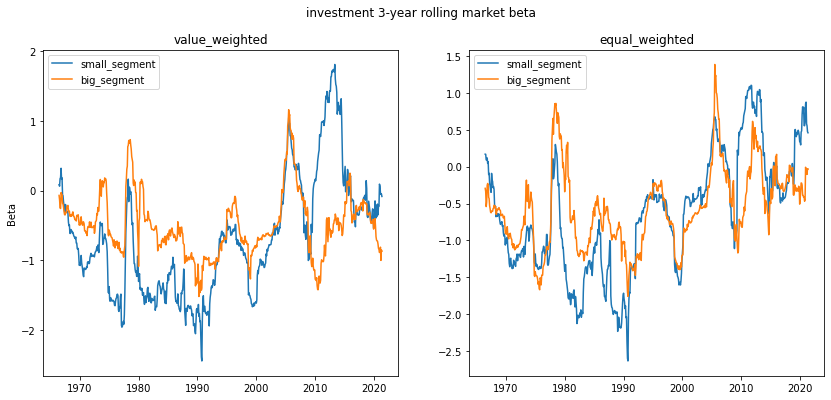

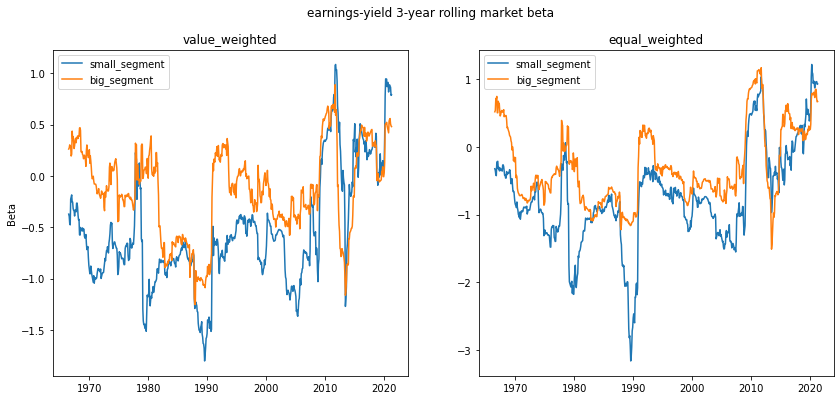

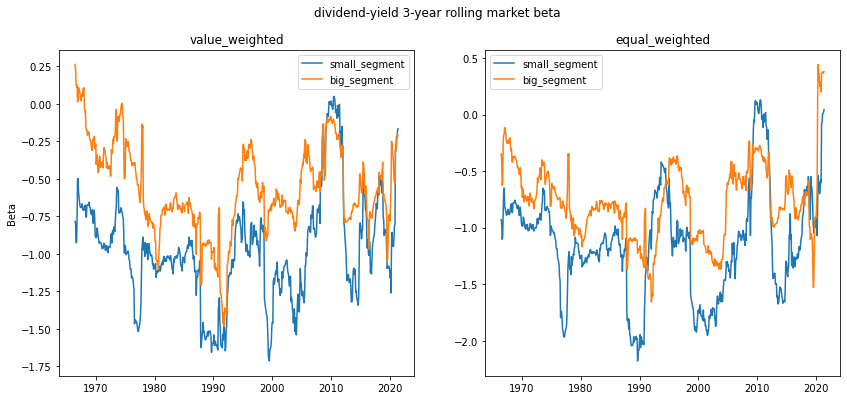

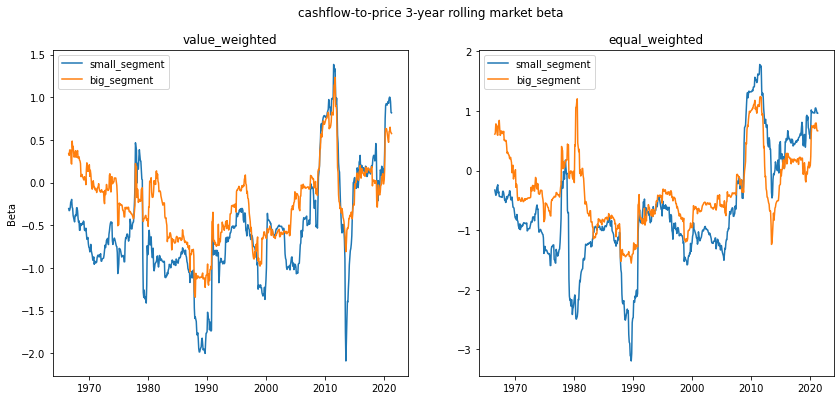

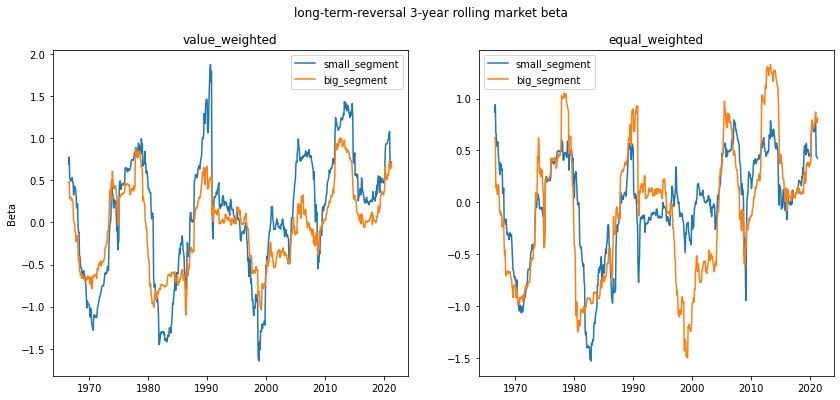

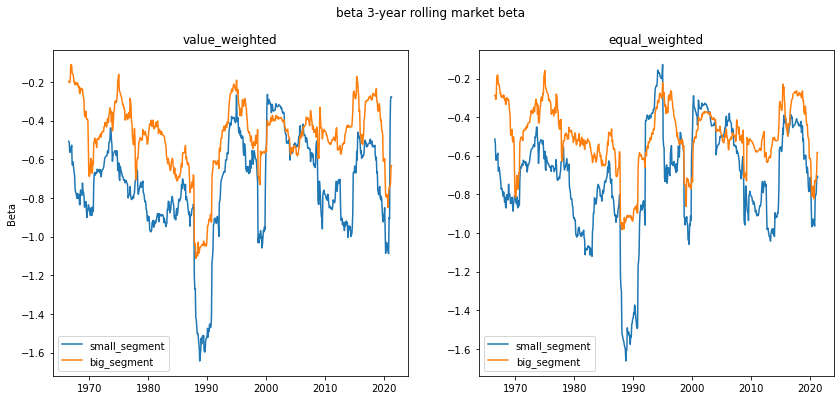

In [9]:
# plot rolling 3-year market beta
for factor in portfolios.keys():
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14,6))
    for i, weight in enumerate(portfolios[factor].keys()):
        df = portfolios[factor][weight]['returns_beta'].copy()
        sns.lineplot(data = df['beta_ls_small'], ax = ax[i], label = 'small_segment')
        sns.lineplot(data = df['beta_ls_big'], ax = ax[i], label = 'big_segment')
        
        ax[i].set_xlabel('')
        ax[i].set_title(weight)
    ax[0].set_ylabel('Beta')
    ax[1].set_ylabel('')
    fig.suptitle(factor + ' 3-year rolling market beta')


In [10]:
# construct beta-neutral portfolio by adjusting weights of high and low legs such that beta = 0
for factor in portfolios.keys():
    for weight in portfolios[factor].keys():
        df = portfolios[factor][weight]['returns_beta'].copy()
        for size in ['small', 'big']:
            # assume weight of high leg = 1
            df['weight_low_' + size] = -df['beta_high_' + size] / df['beta_low_' + size]
            
        portfolios[factor][weight]['returns_beta'] = df


In [11]:
# calculate returns of beta-neutral portfolios
for factor in portfolios.keys():
    for weight in portfolios[factor].keys():
        df = portfolios[factor][weight]['returns_beta'].copy()
        if factor in ['investment', 
                      'net-issuance', 
                      'accruals', 
                      'beta', 
                      'volatility', 
                      'residual-volatility', 
                      'prior-1-month-return', 
                      'long-term-reversal']:
            df['small_ls_bn_ret'] = -df['small_low'] * df['weight_low_small'] - df['small_high']
            df['big_ls_bn_ret'] = -df['big_low'] * df['weight_low_big'] - df['big_high']
        else:
            df['small_ls_bn_ret'] = df['small_high'] + df['small_low'] * df['weight_low_small']
            df['big_ls_bn_ret'] = df['big_high'] + df['big_low'] * df['weight_low_big']
        df['mean_ls_bn_ret'] = 0.5*df['small_ls_bn_ret'] + 0.5*df['big_ls_bn_ret']
        portfolios[factor][weight]['returns_beta'] = df


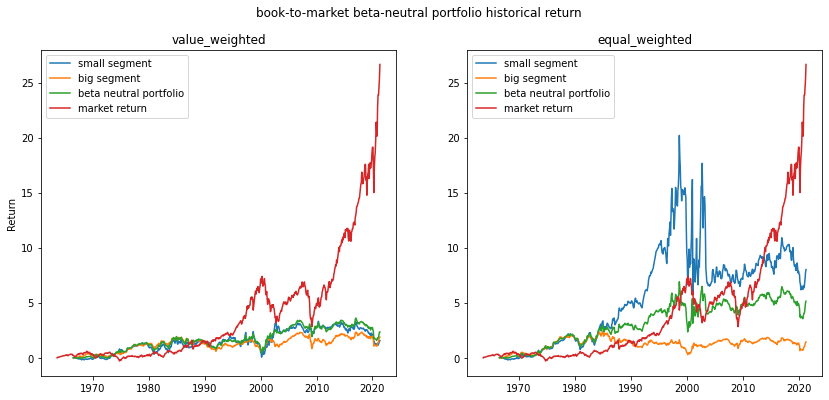

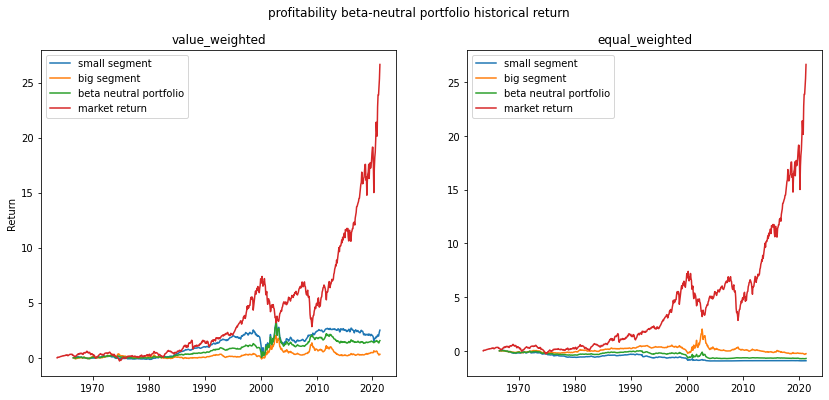

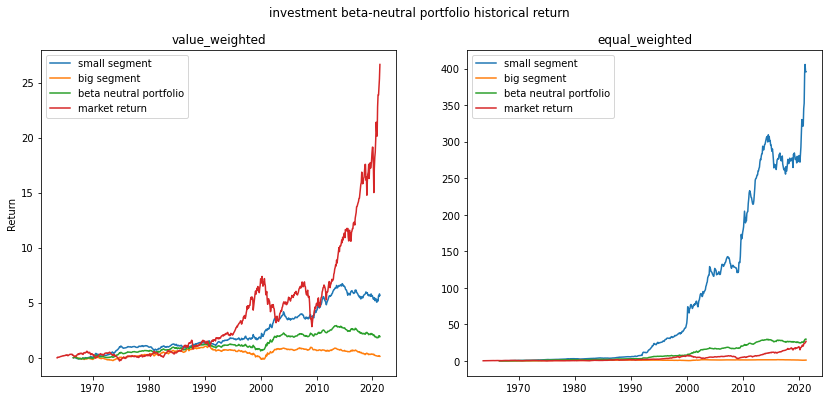

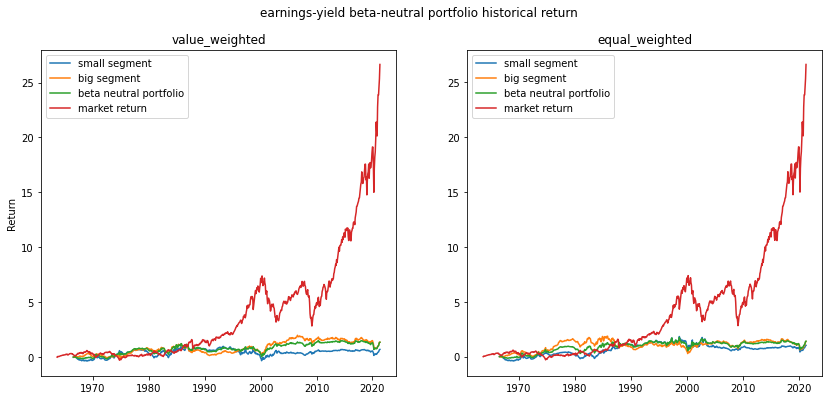

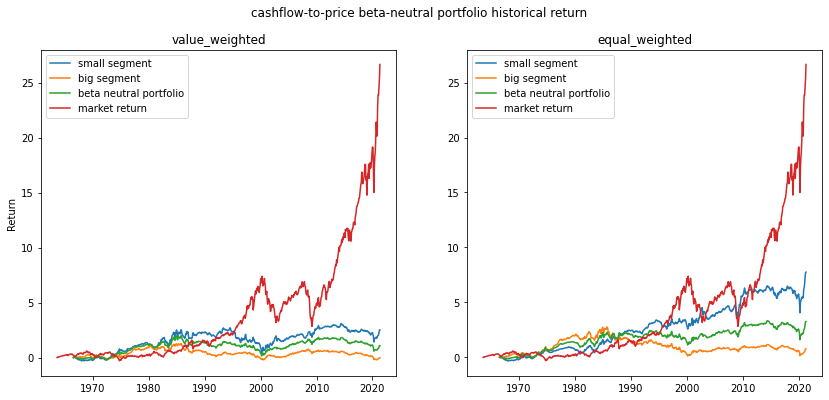

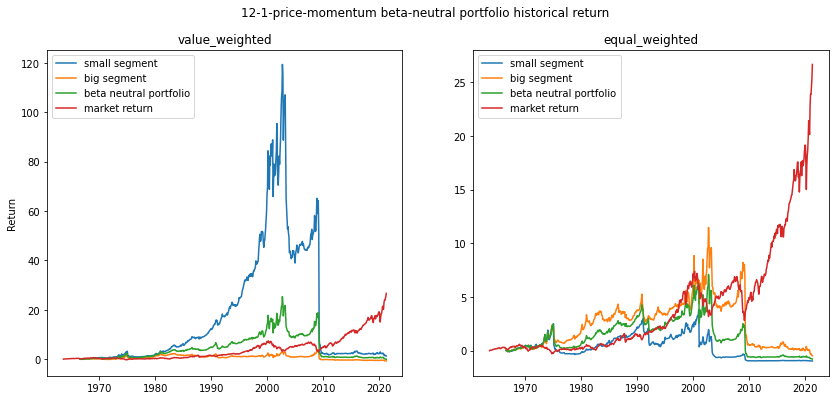

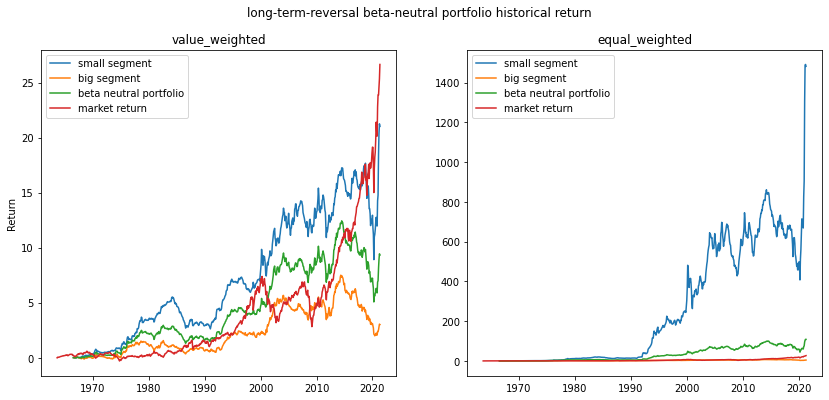

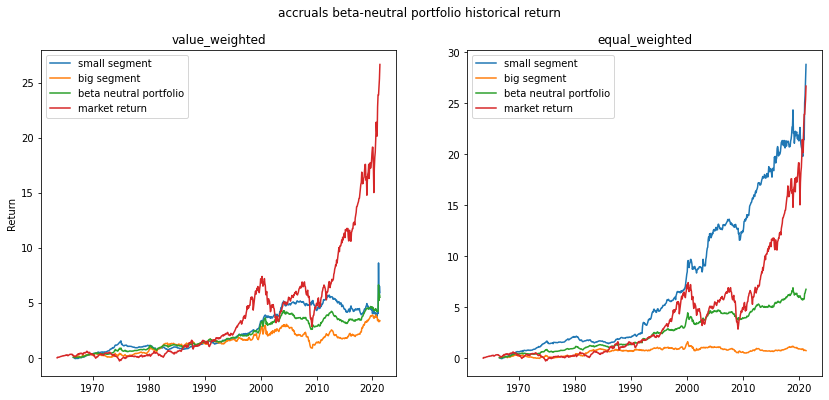

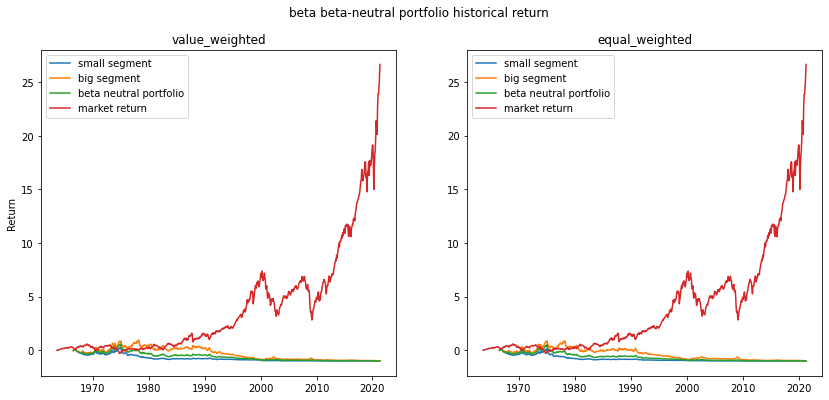

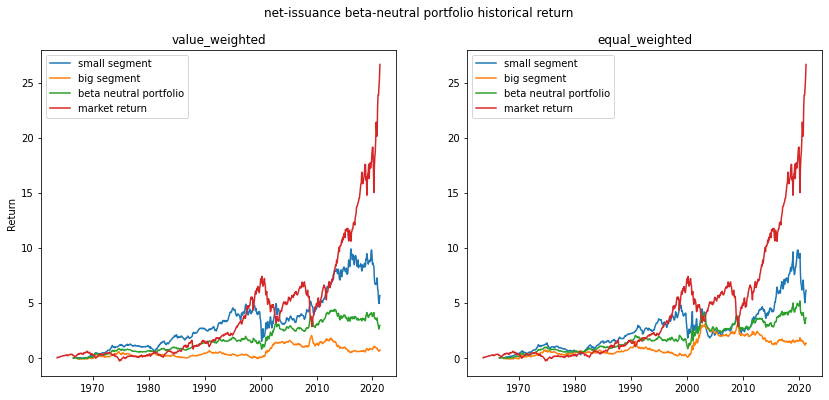

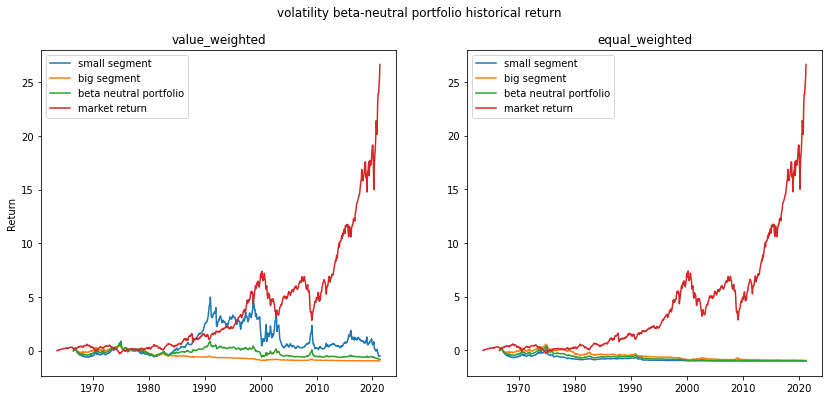

In [12]:
# plot historical returns of beta neutral portfolios
for factor in portfolios.keys():
    fig, ax = plt.subplots(1,2, figsize = (14,6))
    for i, weight in enumerate(portfolios[factor].keys()):
        df = portfolios[factor][weight]['returns_beta'].copy()
        sns.lineplot(data = cum_ret(df['small_ls_bn_ret']), ax = ax[i], label = 'small segment')
        sns.lineplot(data = cum_ret(df['big_ls_bn_ret']), ax = ax[i], label = 'big segment')
        sns.lineplot(data = cum_ret(df['mean_ls_bn_ret']), ax = ax[i], label = 'beta neutral portfolio')
        sns.lineplot(data = cum_ret(ff_model.query(qry)['Mkt-RF']), ax = ax[i], label = 'market return')
        
        ax[i].set_xlabel('')
        ax[i].set_title(weight)
    ax[0].set_ylabel('Return')
    ax[1].set_ylabel('')
    fig.suptitle(factor + ' beta-neutral portfolio historical return')
    
qry = "index >= '1966-06-30'"


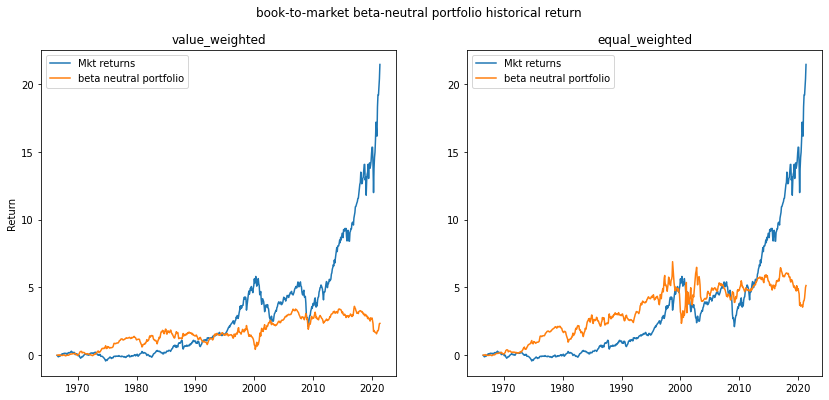

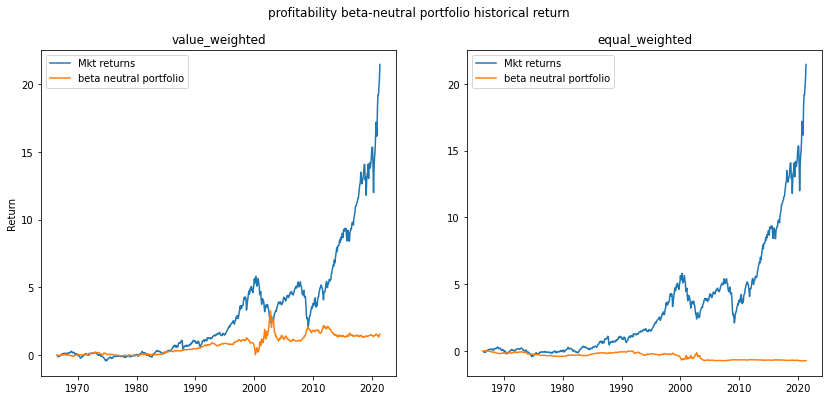

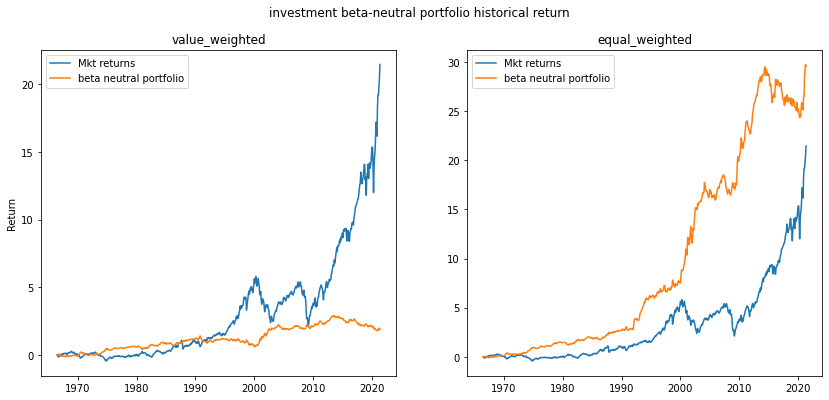

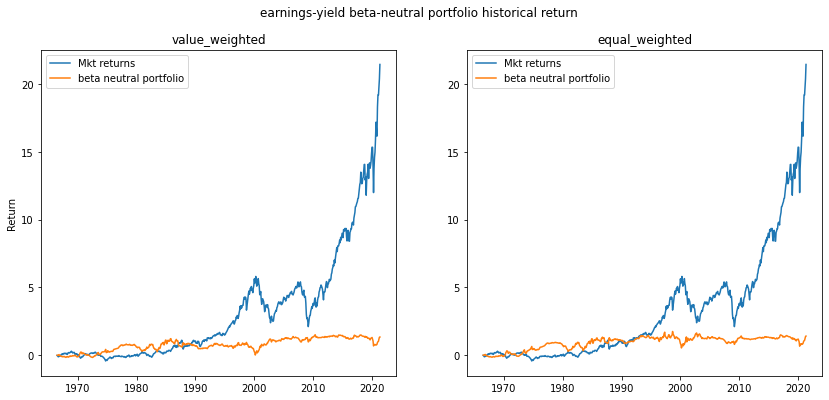

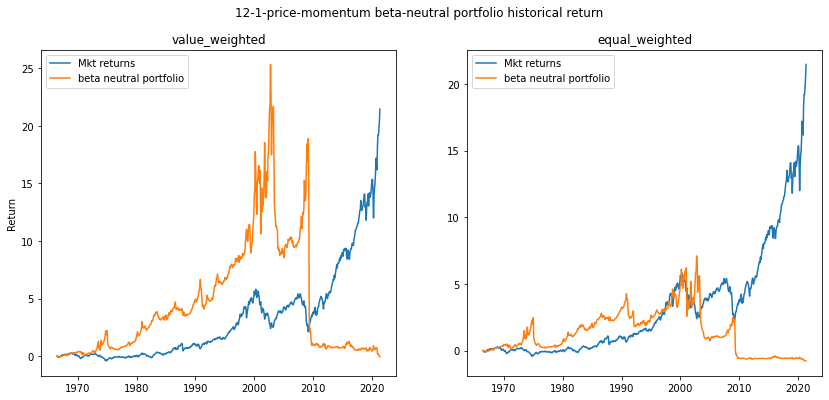

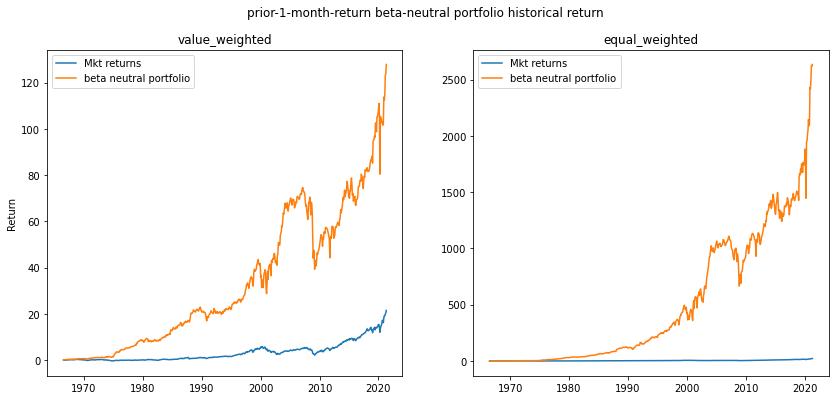

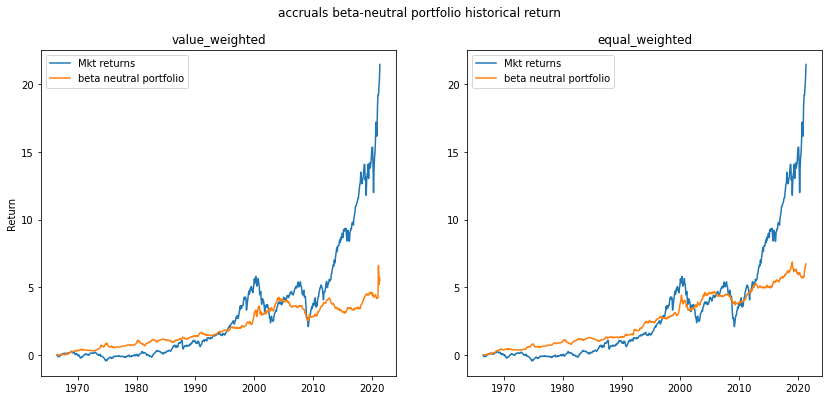

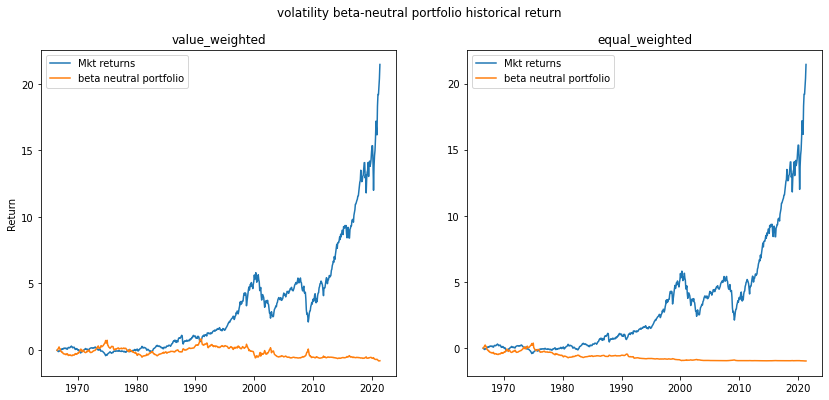

In [13]:
# plot historical returns of beta neutral portfolios against market excess returns
for factor in portfolios.keys():
    fig, ax = plt.subplots(1,2, figsize = (14,6))
    for i, weight in enumerate(portfolios[factor].keys()):
        df = portfolios[factor][weight]['returns_beta'].copy()
        sns.lineplot(data = cum_ret(ff_model.query(qry)['Mkt-RF']), ax = ax[i], label = 'Mkt returns')
        sns.lineplot(data = cum_ret(df['mean_ls_bn_ret']), ax = ax[i], label = 'beta neutral portfolio')
        
        ax[i].set_xlabel('')
        ax[i].set_title(weight)
    ax[0].set_ylabel('Return')
    ax[1].set_ylabel('')
    fig.suptitle(factor + ' beta-neutral portfolio historical return')


- Our beta neutral portfolios generally underperform the market portfolio, suggesting that the market component is still the dominant factor for returns attribution
- A few notable exceptions are prior-1-month-return and long-term-reversal, which have outperformed the market, especially when considering the equal weighted construction. This suggests that these factors have greater explanatory power for smaller cap stocks where there may be more inefficiencies

In [14]:
# =============================================================================
# PART 2
# =============================================================================

## calculate full sample correlation matrix of unadjusted factor returns 

# combine all factor returns to single dataframe 
factor_returns = {'equal_weighted' : {},
                  'value_weighted' : {}}

for weight in factor_returns.keys():
    df_factor_returns = pd.DataFrame()
    for factor in portfolios.keys():
        df = portfolios[factor][weight]['returns_beta'].copy()
        df_ls_ret = pd.DataFrame(df[['small_ls_ret', 'big_ls_ret']].mean(axis = 1))
        df_ls_ret.columns = [factor + '_ls_ret']
        df_factor_returns = pd.concat([df_factor_returns, df_ls_ret], axis = 1)
    factor_returns[weight]['factor_returns'] = df_factor_returns


In [15]:
factor_returns['value_weighted']['factor_returns']

book-to-market_ls_ret  profitability_ls_ret  investment_ls_ret  \
Date                                                                         
1963-07-31               -0.93600               0.65645           -1.14985   
1963-08-31                1.81905               0.39540           -0.39865   
1963-09-30                0.17470              -0.76495            0.23945   
1963-10-31               -0.03695               2.74845           -2.24200   
1963-11-30                1.70460              -0.44595            2.21955   
...                           ...                   ...                ...   
2020-12-31               -1.35915              -2.14730           -0.00190   
2021-01-31                2.85125              -3.33105            4.68175   
2021-02-28                7.08005               0.08850           -1.96800   
2021-03-31                7.39730               6.43055            3.43670   
2021-04-30               -0.74575               2.26315           -2.70965   

            earnings-yield_ls_ret  dividend-yield_ls_ret  \
Date                                                       
1963-07-31                  1.000                  0.555   
1963-08-31                 -0.120                 -1.285   
1963-09-30                 -0.540                  1.110   
1963-10-31                  1.690                  0.910   
1963-11-30                 -1.720                 -0.765   
...                           ...                    ...   
2020-12-31                  1.255                 -0.360   
2021-01-31                  1.085                  2.145   
2021-02-28                  6.835                  5.240   
2021-03-31                  6.055                  2.955   
2021-04-30                 -0.460                 -0.880   

            cashflow-to-price_ls_ret  12-1-price-momentum_ls_ret  \
Date                                                               
1963-07-31                    -0.210                       0.995   
1963-08-31                     0.240                       1.030   
1963-09-30                     0.250                       0.165   
1963-10-31                     0.065                       3.145   
1963-11-30                     0.465                      -0.755   
...                              ...                         ...   
2020-12-31                    -0.845                      -2.415   
2021-01-31                     0.900                       4.345   
2021-02-28                     5.825                      -7.670   
2021-03-31                     6.300                      -5.830   
2021-04-30                    -1.500                       1.020   

            prior-1-month-return_ls_ret  long-term-reversal_ls_ret  \
Date                                                                 
1963-07-31                       -0.025                     -1.050   
1963-08-31                        1.405                      1.575   
1963-09-30                        1.190                     -0.085   
1963-10-31                       -0.665                     -0.210   
1963-11-30                        1.160                      0.005   
...                                 ...                        ...   
2020-12-31                       -3.080                     -0.585   
2021-01-31                        0.380                      9.190   
2021-02-28                        4.110                      4.105   
2021-03-31                       -0.300                      3.290   
2021-04-30                        1.680                     -1.865   

            accruals_ls_ret  beta_ls_ret  net-issuance_ls_ret  \
Date                                                            
1963-07-31          1.85790      1.45580             -1.43750   
1963-08-31          1.02080     -4.73780             -0.91995   
1963-09-30         -0.14735      0.27845             -0.23405   
1963-10-31          6.72780     -2.47290             -0.35565   
1963-11-30         -1.55920   

In [16]:
# # regress factor returns on lagged factor returns and calculate p-value
# for factor in portfolios.keys():
#     for weight in portfolios[factor].keys():
#         df = portfolios[factor][weight]['returns_beta'][['mean_ls_ret']].copy()
#         df['lagged_12m'] = df['mean_ls_ret'].shift(12)
#         df['lagged_36m'] = df['mean_ls_ret'].shift(36)
#         df.dropna(inplace = True)
#         x = np.array(df[['lagged_12m', 'lagged_36m']])
#         y = df['mean_ls_ret']
#         x = sm.add_constant(x)
        
#         model = sm.OLS(endog = y, exog = x).fit()
#         pvalues = np.array(model.pvalues)
        
#         df_persistence = pd.DataFrame(pvalues.reshape(1,-1), columns = ['const', 'lagged_12m', 'lagged_36m'])
#         df_persistence['factor'] = factor
#         df_persistence['weight'] = weight
        
#         portfolios[factor][weight]['return_persistence_factor'] = df_persistence().plot()


In [17]:
data = factor_returns['equal_weighted']['factor_returns'].copy()
data.columns=(['book-to-market',
               'profitability',
               'investment',
               'earnings-yield',
               'dividend-yield',
               'cashflow-to-price',
               '12-1-price-momentum',
               'prior-1-month-return',
               'long-term reversal',
               'accruals','beta',
               'net-issuance',
               'volatility',
               'residual-volatility'])

cor_matrix = data.corr()
cov_matrix = data.cov()

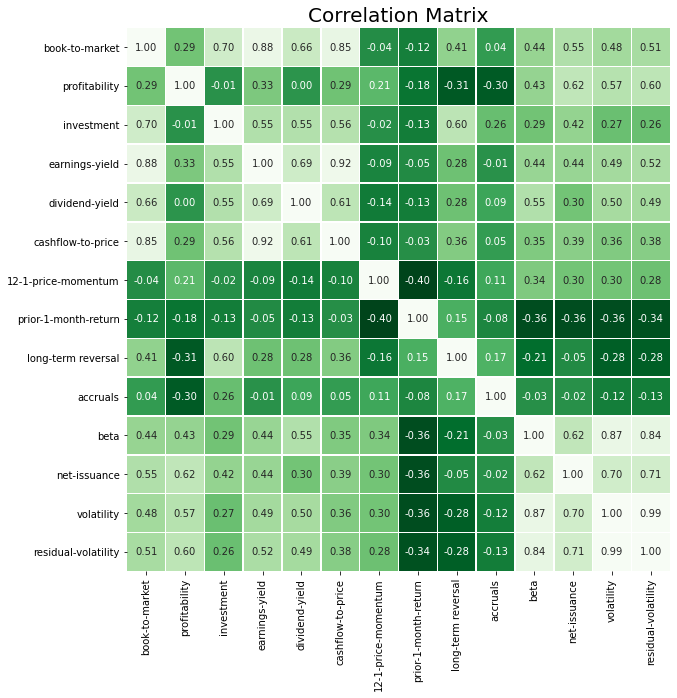

In [18]:
# plot correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(cor_matrix, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Greens_r', cbar=False);
plt.title('Correlation Matrix', fontsize = 20)
plt.show()

In [19]:
# Prior One Month has negative correlation with other factors


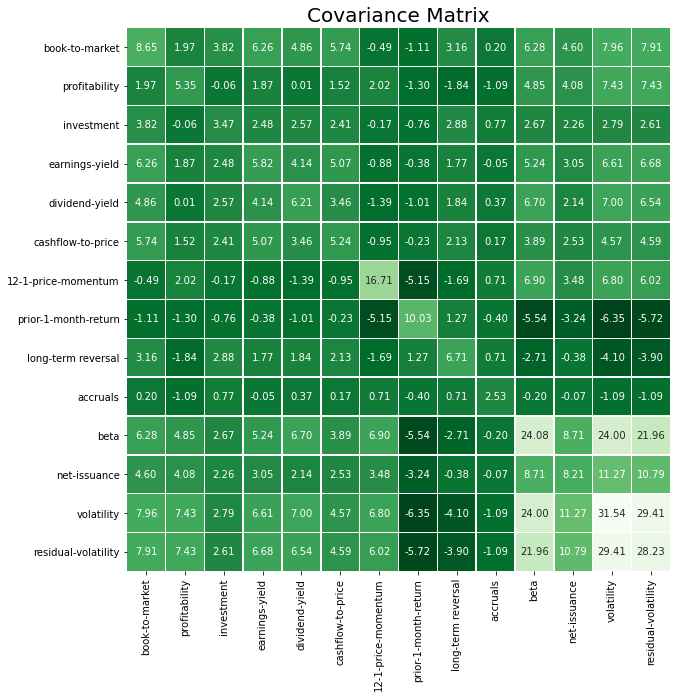

In [20]:
# plot covariance matrix
plt.figure(figsize=(10,10))
sns.heatmap(cov_matrix, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Greens_r', cbar=False);
plt.title('Covariance Matrix', fontsize = 20)
plt.show()

Mariginal Risk Contribution formula:

$ MRC_i = \frac{\partial \sigma_p}{\partial w_i } = \frac{1}{\sigma_p} \sum^n_j w_j cov(r_i, r_j) $

Risk Contribution of asset i

$ RC_i = MRC_i * wi $

If portfolio has equal risk weight:

$RC_i = \frac{1}{14} * \sigma_p$

In [21]:
1/14, 1/14

(0.07142857142857142, 0.07142857142857142)

In [22]:
# define objective function for optmization
def f(starting_guess, covariance_matrix):
    
    #create weight matrix
    starting_guess_matrix = np.matrix(starting_guess).T
    
    #create covariance matrix
    cov_matrix = np.matrix(covariance_matrix)
    
    #calculate portfolio variance =W.T * V * W
    portfolio_var = (starting_guess_matrix.T * cov_matrix * starting_guess_matrix)[0,0]
    portfolio_sigma = np.sqrt(portfolio_var)
    
    #Marginal Risk Contribution = Cov_Matrix * W
    MRC_matrix = cov_matrix*starting_guess_matrix / portfolio_sigma
    
    #Factor Risk = respective Mariginal Risk Contribution x repsective weight
    factor_risk = np.multiply(MRC_matrix, starting_guess_matrix)
    
    #if all factor contribute equal weight, all the risk will equal to portfolio variance * 1/14
    equal_risk = np.matrix(np.array([1/14]*14)).T
    equal_risk = np.multiply(equal_risk, portfolio_sigma)
    
    #error equal to the differene between factor risk and equal risk matrix
    error = sum(np.square(factor_risk - equal_risk))[0,0]
    
    return error

## If we do not allow negative weight,  Use below Constrain:

In [23]:
# define a optmization function
def equal_risk_weight(starting_guess, covariance_matrix):

    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1.0}, # total weight sum = 1
            {'type': 'ineq', 'fun': lambda x: x}) # weight of each factor >= 0
    
    result= minimize(f, starting_guess, args=(covariance_matrix) ,constraints=cons)
    return result.x

## If we allow negative weight, Use below Constrain:

In [24]:
# from scipy.optimize import minimize

# # define a optmization function
# def equal_risk_weight(starting_guess, covariance_matrix):

#     cons = ({'type': 'eq', 'fun': lambda x: np.sum(abs(x))-1.0}) # total weight sum = 1
    
#     result= minimize(f, starting_guess, args=(covariance_matrix) ,constraints=cons)
#     return result.x

In [25]:
#create an empty dataframe to store weights
weight_df = pd.DataFrame(columns = ['book-to-market', 'profitability', 'investment', 'earnings-yield',
       'dividend-yield', 'cashflow-to-price', '12-1-price-momentum',
       'prior-1-month-return', 'long-term reversal', 'accruals', 'beta',
       'net-issuance', 'volatility', 'residual-volatility'])

In [26]:
#for loop to calculate the weight with rolling window of 5 years (60 months)
starting_guess = np.array([1/14]*14)

for i in range(len(data)-61):
    covariance_matrix = data.iloc[i:i+60].cov()
    weight_df.loc[len(weight_df.index)] = equal_risk_weight(starting_guess, covariance_matrix)

In [27]:
weight_df.head()

book-to-market  profitability  investment  earnings-yield  dividend-yield  \
0        0.078289  -9.269846e-17    0.056272        0.086184        0.040082   
1        0.076273   6.033910e-17    0.058771        0.083862        0.040571   
2        0.076221  -3.562031e-17    0.058616        0.084143        0.040767   
3        0.075715   1.359068e-17    0.058459        0.083468        0.040804   
4        0.075728  -5.129015e-17    0.058743        0.082816        0.040836   

   cashflow-to-price  12-1-price-momentum  prior-1-month-return  \
0           0.083864        -1.054838e-17              0.183521   
1           0.082769         5.219225e-17              0.211386   
2           0.082705         1.503713e-16              0.212364   
3           0.082755        -9.624793e-18              0.213534   
4           0.082559        -1.166593e-16              0.207782   

   long-term reversal  accruals      beta  net-issuance  volatility  \
0            0.106533  0.105076  0.049583      0.139711    0.034021   
1            0.093517  0.097431  0.050338      0.133103    0.034467   
2            0.092839  0.097127  0.050455      0.132671    0.034531   
3            0.091836  0.099639  0.050205      0.131447    0.034518   
4            0.092313  0.102215  0.050092      0.136340    0.033748   

   residual-volatility  
0             0.036863  
1             0.037512  
2             0.037561  
3             0.037620  
4             0.036827

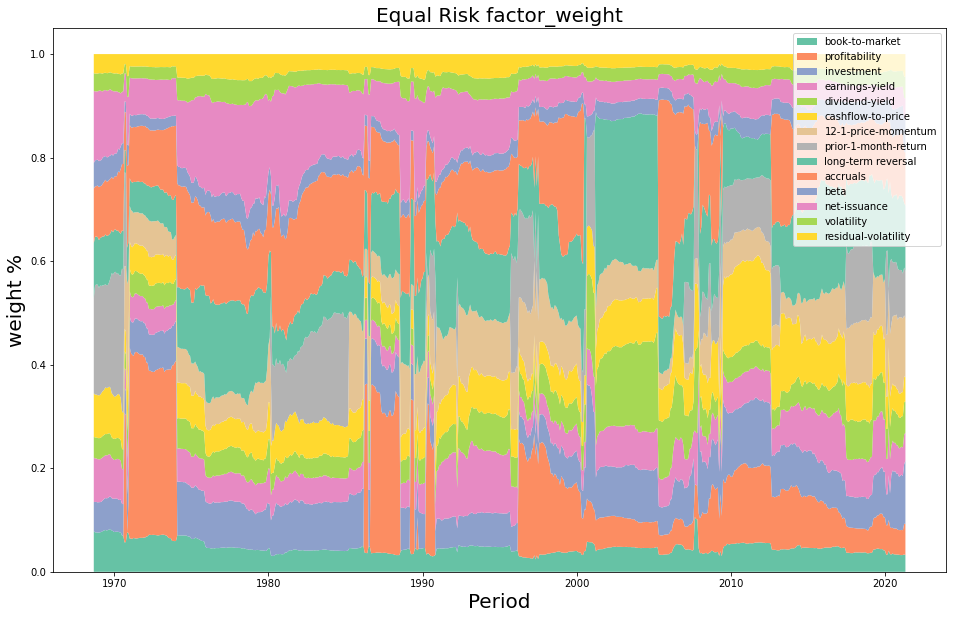

In [28]:
# Plot the monthly factor weights over time
col = sns.color_palette("Set2", 15)
weight_dict = abs(weight_df).to_dict('list')
fig, ax = plt.subplots(figsize=(16,10))
ax.stackplot(data.iloc[61:,:].index, weight_dict.values(),
             labels=weight_dict.keys(), colors = col)
ax.legend(loc='upper right')
ax.set_title('Equal Risk factor_weight', fontsize = 20)
ax.set_xlabel('Period', fontsize = 20)
ax.set_ylabel('weight %', fontsize = 20)

plt.show()

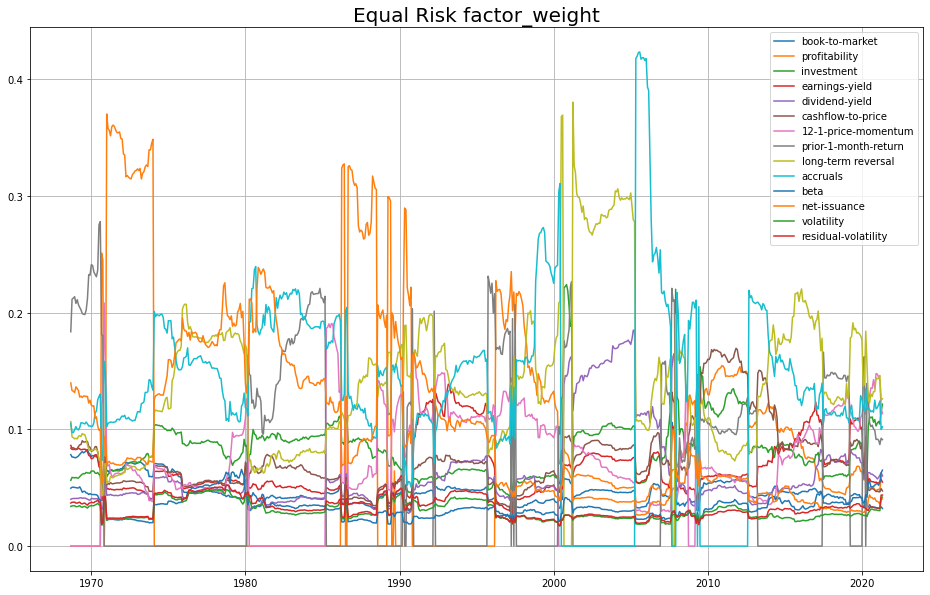

In [29]:
#Plot the monthly factor weights over time
def plot_function(df):
    plt.figure(figsize = (16,10))
    
    for column_name in df.columns:
        plt.plot(data.iloc[61:,:].index,abs(df[column_name]), label = column_name)
        
    plt.grid()    
    plt.legend(fontsize = 10)
    plt.title('Equal Risk factor_weight', fontsize = 20)
    plt.show()
    
plot_function(weight_df)


In [30]:
Comparison_df = pd.DataFrame(columns = ['equal_weight_return', 'equal_risk_return'])
for i in range(len(weight_df)): # from 61th month (inclusive) onward
    returns = np.matrix(data.iloc[i+61,:].values)
    risk_weights = np.matrix(weight_df.iloc[i,:].values).T
    equal_risk_return = (returns*risk_weights)[0,0]
    
    equal_weights = np.matrix([1/14]*14).T
    equal_weight_return = (returns*equal_weights)[0,0]
    Comparison_df.loc[len(Comparison_df.index)] = [equal_weight_return, equal_risk_return]
  

## Plot cumulative return using  .cumsum(), assuming log return

In [31]:
# plot returns for both equal risk and equal weight strategies
plt.figure(figsize = (10,6))
plt.plot(data.iloc[61:,:].index,Comparison_df['equal_risk_return'].cumsum(), label = 'equal_risk_return')
plt.plot(data.iloc[61:,:].index,Comparison_df['equal_weight_return'].cumsum(), label = 'equal_weight_return')
plt.title('Equal Risk Return VS Equal Weight Return', fontsize = 20)
plt.legend(fontsize = 10)
plt.grid()
plt.show()

## Plot cumulative return using  .cumprod(), assuming Simple Return

In [32]:
# plot returns for both equal risk and equal weight strategies
plt.figure(figsize = (10,6))
plt.plot(data.iloc[61:,:].index,(Comparison_df['equal_risk_return']/100+1).cumprod()-1, label = 'equal_risk_return')
plt.plot(data.iloc[61:,:].index,(Comparison_df['equal_weight_return']/100+1).cumprod()-1, label = 'equal_weight_return')
plt.title('Equal Risk Return VS Equal Weight Return', fontsize = 20)
plt.legend(fontsize = 10)
plt.grid()
plt.show()

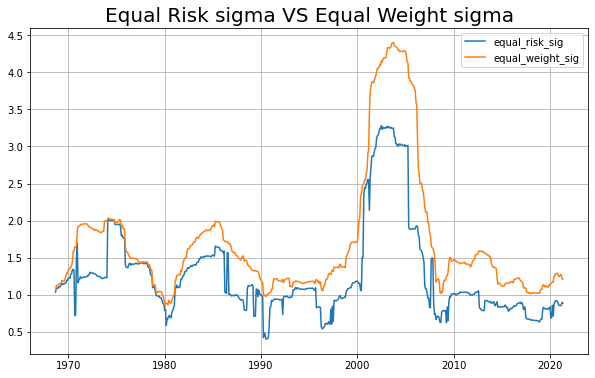

In [33]:
# Just Plotting the rolling portfolio risk for reference

Risk_Comparison_df = pd.DataFrame(columns = ['equal_risk_sig', 'equal_weight_sig'])
for i in range(len(weight_df)): # from 61th month (inclusive) onward
    
    covariance_matrix = data.iloc[i:i+60].cov()
    cov_matrix = np.matrix(covariance_matrix)
    risk_weights = np.matrix(weight_df.iloc[i,:].values).T
    equal_risk_vol = (risk_weights.T*cov_matrix*risk_weights)[0,0]
    equal_risk_sig = np.sqrt(equal_risk_vol)
    
    equal_weights = np.matrix([1/14]*14).T
    equal_weight_vol = (equal_weights.T*cov_matrix*equal_weights)[0,0]
    equal_weight_sig = np.sqrt(equal_weight_vol)
    Risk_Comparison_df.loc[len(Risk_Comparison_df.index)] = [equal_risk_sig, equal_weight_sig ]

plt.figure(figsize = (10,6))
plt.plot(data.iloc[61:,:].index,Risk_Comparison_df['equal_risk_sig'], label= 'equal_risk_sig')
plt.plot(data.iloc[61:,:].index,Risk_Comparison_df['equal_weight_sig'], label= 'equal_weight_sig')
plt.title('Equal Risk sigma VS Equal Weight sigma', fontsize = 20)
plt.legend(fontsize = 10)
plt.grid()
plt.show()

### Part 3

#### Factor persistence

Text(0.5, 1.0, 'equal weighted')

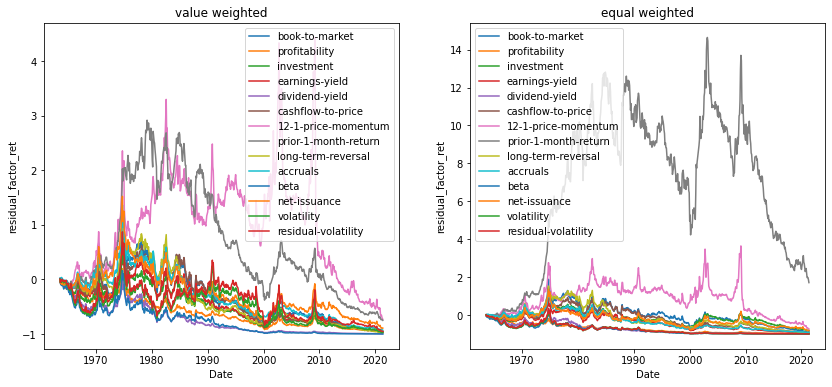

In [34]:
# =============================================================================
# Part 3
# =============================================================================

# residual returns over market for each factor
fig, ax = plt.subplots(1,2, figsize = (14,6))
for factor in portfolios.keys():
    for i, weight in enumerate(portfolios[factor].keys()):
        df = portfolios[factor][weight]['returns_beta'].copy()
        df['residual_factor_ret'] = df['mean_ls_ret'] - df['Mkt-RF']
        portfolios[factor][weight]['returns_beta'] = df
        
        sns.lineplot(data = cum_ret(df['residual_factor_ret']), ax = ax[i], label = factor)
ax[0].set_title('value weighted')
ax[1].set_title('equal weighted')

In [35]:
# returns for each factor
fig, ax = plt.subplots(1,2, figsize = (14,6))
for factor in portfolios.keys():
    for i, weight in enumerate(portfolios[factor].keys()):
        df = portfolios[factor][weight]['returns_beta'].copy()
        
        sns.lineplot(data = cum_ret(df['mean_ls_ret']), ax = ax[i], label = factor)
ax[0].set_title('value weighted')
ax[1].set_title('equal weighted')

Text(0.5, 1.0, 'equal weighted')

- Looking at the above chart and referring to the returns chart for individual factors above, we can see that factor returns have not been going up continuously, with periods of big up-and-down swings. This suggests some mean-reversion characteristics in which factor persistence is low.
- An auxilliary test using regression tests of factor returns against lagged factor returns also produced low p-values, indicating low autocorrelation of factor returns and hence persistence.

In [36]:
# regress residual returns on lagged residual returns and calculate p-value
for factor in portfolios.keys():
    for weight in portfolios[factor].keys():
        df = portfolios[factor][weight]['returns_beta'][['residual_factor_ret']].copy()
        df['lagged_12m'] = df['residual_factor_ret'].shift(12)
        df['lagged_36m'] = df['residual_factor_ret'].shift(36)
        df.dropna(inplace = True)
        x = np.array(df[['lagged_12m', 'lagged_36m']])
        y = df['residual_factor_ret']
        x = sm.add_constant(x)
        
        model = sm.OLS(endog = y, exog = x).fit()
        pvalues = np.array(model.pvalues)
        
        df_persistence = pd.DataFrame(pvalues.reshape(1,-1), 
                                      columns = ['const', 'lagged_12m', 'lagged_36m'])
        df_persistence['factor'] = factor
        df_persistence['weight'] = weight
        
        portfolios[factor][weight]['residual_persistence_factor'] = df_persistence


In [37]:
# combine pvalues into dataframe
df_pvalues_residual_ret = pd.DataFrame(columns = ['const', 'lagged_12m', 'lagged_36m', 'factor', 'weight'])
for factor in portfolios.keys():
    for weight in portfolios[factor].keys():
        df = portfolios[factor][weight]['residual_persistence_factor'].copy()
        df_pvalues_residual_ret = pd.concat([df_pvalues_residual_ret, df], axis = 0)


In [59]:
df_pvalues_residual_ret

const  lagged_12m  lagged_36m                factor          weight
0  0.157173    0.589566    0.604735        book-to-market  value_weighted
0  0.546495    0.200470    0.585450        book-to-market  equal_weighted
0  0.130833    0.637969    0.588111         profitability  value_weighted
0  0.021379    0.792587    0.874907         profitability  equal_weighted
0  0.146531    0.870536    0.133791            investment  value_weighted
0  0.686995    0.903758    0.170401            investment  equal_weighted
0  0.155114    0.323761    0.496223        earnings-yield  value_weighted
0  0.176533    0.206654    0.454094        earnings-yield  equal_weighted
0  0.027091    0.712244    0.339823        dividend-yield  value_weighted
0  0.028260    0.976013    0.328776        dividend-yield  equal_weighted
0  0.133453    0.849162    0.634600     cashflow-to-price  value_weighted
0  0.245758    0.730462    0.550375     cashflow-to-price  equal_weighted
0  0.999288    0.273539    0.647571   12-1-price-momentum  value_weighted
0  0.968582    0.174549    0.426062   12-1-price-momentum  equal_weighted
0  0.613432    0.336983    0.691667  prior-1-month-return  value_weighted
0  0.235094    0.109222    0.780741  prior-1-month-return  equal_weighted
0  0.066240    0.100065    0.399033    long-term-reversal  value_weighted
0  0.244685    0.091393    0.733545    long-term-reversal  equal_weighted
0  0.156396    0.534833    0.271754              accruals  value_weighted
0  0.144717    0.787174    0.325857              accruals  equal_weighted
0  0.113576    0.696862    0.802013                  beta  value_weighted
0  0.087506    0.869353    0.935211                  beta  equal_weighted
0  0.511481    0.824207    0.334281          net-issuance  value_weighted
0  0.899198    0.290146    0.190819          net-issuance  equal_weighted
0  0.946751    0.956919    0.387745            volatility  value_weighted
0  0.307372    0.932191    0.857358            volatility  equal_weighted
0  0.994226    0.665140    0.580839   residual-volatility  value_weighted
0  0.283742    0.969805    0.890600   residual-volatility  equal_weighted

In [38]:
# regress factor returns on lagged factor returns and calculate p-value
for factor in portfolios.keys():
    for weight in portfolios[factor].keys():
        df = portfolios[factor][weight]['returns_beta'][['mean_ls_ret']].copy()
        df['lagged_12m'] = df['mean_ls_ret'].shift(12)
        df['lagged_36m'] = df['mean_ls_ret'].shift(36)
        df.dropna(inplace = True)
        x = np.array(df[['lagged_12m', 'lagged_36m']])
        y = df['mean_ls_ret']
        x = sm.add_constant(x)
        
        model = sm.OLS(endog = y, exog = x).fit()
        pvalues = np.array(model.pvalues)
        
        df_persistence = pd.DataFrame(pvalues.reshape(1,-1), columns = ['const', 'lagged_12m', 'lagged_36m'])
        df_persistence['factor'] = factor
        df_persistence['weight'] = weight
        
        portfolios[factor][weight]['return_persistence_factor'] = df_persistence


In [39]:
# combine pvalues into dataframe
df_pvalues_factor_ret = pd.DataFrame(columns = ['const', 'lagged_12m', 'lagged_36m', 'factor', 'weight'])
for factor in portfolios.keys():
    for weight in portfolios[factor].keys():
        df = portfolios[factor][weight]['return_persistence_factor'].copy()
        df_pvalues_factor_ret = pd.concat([df_pvalues_factor_ret, df], axis = 0)

In [60]:
df_pvalues_factor_ret

const  lagged_12m  lagged_36m                factor          weight
0  3.855720e-02    0.680429    0.224850        book-to-market  value_weighted
0  3.525631e-04    0.132126    0.099234        book-to-market  equal_weighted
0  1.880035e-03    0.235634    0.514293         profitability  value_weighted
0  3.108419e-01    0.648934    0.007096         profitability  equal_weighted
0  2.994901e-04    0.545959    0.369614            investment  value_weighted
0  8.167324e-10    0.926921    0.666707            investment  equal_weighted
0  1.012627e-02    0.257885    0.535778        earnings-yield  value_weighted
0  1.438626e-03    0.032677    0.807943        earnings-yield  equal_weighted
0  8.299953e-01    0.442261    0.984338        dividend-yield  value_weighted
0  5.930789e-01    0.940995    0.925536        dividend-yield  equal_weighted
0  2.603616e-02    0.805616    0.198355     cashflow-to-price  value_weighted
0  6.282948e-04    0.333274    0.126306     cashflow-to-price  equal_weighted
0  4.069485e-03    0.038300    0.107766   12-1-price-momentum  value_weighted
0  5.266671e-03    0.029467    0.014399   12-1-price-momentum  equal_weighted
0  1.271860e-04    0.962310    0.751396  prior-1-month-return  value_weighted
0  6.403236e-08    0.146524    0.249333  prior-1-month-return  equal_weighted
0  9.488859e-02    0.000685    0.995061    long-term-reversal  value_weighted
0  1.897858e-02    0.000004    0.017862    long-term-reversal  equal_weighted
0  1.316982e-03    0.033460    0.900257              accruals  value_weighted
0  5.645986e-06    0.076152    0.349857              accruals  equal_weighted
0  7.795802e-01    0.574836    0.444059                  beta  value_weighted
0  9.978702e-01    0.920744    0.308025                  beta  equal_weighted
0  2.307446e-05    0.684472    0.947582          net-issuance  value_weighted
0  2.849516e-07    0.012522    0.728300          net-issuance  equal_weighted
0  1.316229e-02    0.776702    0.766310            volatility  value_weighted
0  3.823513e-01    0.296924    0.263597            volatility  equal_weighted
0  5.112218e-03    0.967144    0.834439   residual-volatility  value_weighted
0  3.779126e-01    0.294750    0.096999   residual-volatility  equal_weighted

#### Use historical Sharpe ratio to weight factors and build adaptive factor models 

In [40]:
# calculate historical Sharpe ratio
def calc_rolling_sr(ret, window = 12):
    rolling_ret = ret.rolling(window).mean()
    rolling_sd = ret.rolling(window).std()
    
    return rolling_ret / rolling_sd

In [41]:
# calculate rolling sharpe ratio on beta neutral factors 
for factor in portfolios.keys():
    for weight in portfolios[factor].keys():
        df = portfolios[factor][weight]['returns_beta'].copy()
        df['rolling_12m_sr'] = calc_rolling_sr(df['mean_ls_bn_ret'], window = 12)
        df['rolling_36m_sr'] = calc_rolling_sr(df['mean_ls_bn_ret'], window = 36)
        
        portfolios[factor][weight]['returns_beta'] = df

In [42]:
# combine all factor returns and sharpe ratio into one dataframe 
factor_dict = {'equal_weighted' : {'12m' : {}, '36m' : {}}, 
               'value_weighted' : {'12m' : {}, '36m' : {}}}

idx = ff_model.query(qry).index

In [43]:
for weight in factor_dict.keys():
    df_ret = pd.DataFrame(index = idx)
    df_12m_sr = pd.DataFrame(index = idx)
    df_36m_sr = pd.DataFrame(index = idx)
    for factor in portfolios.keys():
        df = portfolios[factor][weight]['returns_beta'].copy()
        ret = df[['mean_ls_bn_ret']]
        ret.columns = [factor]
        sr_12m = df[['rolling_12m_sr']]
        sr_12m.columns = [factor]
        sr_36m = df[['rolling_36m_sr']]
        sr_36m.columns = [factor]
        
        df_ret = pd.merge(df_ret, ret, left_index = True, right_index = True)
        df_12m_sr = pd.merge(df_12m_sr, sr_12m, left_index = True, right_index = True)
        df_36m_sr = pd.merge(df_36m_sr, sr_36m, left_index = True, right_index = True)
        
    factor_dict[weight]['12m']['returns'] = df_ret
    factor_dict[weight]['12m']['sr'] = df_12m_sr
    factor_dict[weight]['36m']['returns'] = df_ret
    factor_dict[weight]['36m']['sr'] = df_36m_sr

In [44]:
# convert sharpe ratios into signals
# signal logic: exponent weight factor rolling sharpe ratios 
def calc_zscore(df):
    df_mean = df.mean(axis = 1)
    df_std = df.std(axis = 1)
    df_zscore = df.sub(df_mean, axis = 0).div(df_std, axis = 0)
    
def exponent_weighting(df, p = 0.5):
    num = (-df.sub(df.max(axis = 1), axis = 0) + 1) ** p
    denom = num.sum(axis = 1)
    df_weights = num.div(denom, axis = 0)
    
    return df_weights

Exponent weighting function: 


$w_i = \frac{(max(r) - r_i + 1)^{p}}{\sum \limits_{i}^{n} (max(r) - r_i + 1)^{p}}$


p is a control parameter that adjusts how wide the distribution is. The higher the absolute value of p, the more weights are given to factors with high SR. If p is negative, the inverse weights are given, i.e. higher SR leads to lower weights.

In [45]:
# calculate weights based on rolling sharpe ratio
for weight in factor_dict.keys():
    for window in factor_dict[weight].keys():
        df_sr = factor_dict[weight][window]['sr'].copy().dropna()
        
        # exponent weighting (non-ranked)
        df_weights = pd.DataFrame()
        
        for p in [-10,-5,-3,-1,-0.5,0,0.5,1,3,5,10]:
            df_tmp = exponent_weighting(df_sr, p = p).reset_index()
            df_tmp['p'] = p
            
            df_weights = pd.concat([df_weights, df_tmp])
        
        factor_dict[weight][window]['weights'] = df_weights.reset_index(drop = True)

In [46]:
# backtest using new weights
qry = "index >= '1969-05-31'"

df_backtest = pd.DataFrame()
for weight in factor_dict.keys():
    for window in factor_dict[weight].keys():
        df_weights = factor_dict[weight][window]['weights'].copy()
        df_ret = factor_dict[weight][window]['returns'].copy()
        
        for p in df_weights['p'].unique():            
            df_weights_p = df_weights.query("p == @p").set_index('Date')
            df_weights_p.drop('p', axis = 1, inplace = True)
            df_asset_ret = df_weights_p * df_ret
            df_signal_ret = pd.DataFrame(df_asset_ret.sum(axis = 1))
            df_signal_ret.columns = ['signal_ret']
            df_signal_ret['window'] = window
            df_signal_ret['p'] = p
            df_signal_ret['weight'] = weight
            df_signal_ret.reset_index(inplace = True)
            
            df_backtest = pd.concat([df_backtest, df_signal_ret])

In [47]:
def calc_sr(s):
    return s.mean() / s.std()

def calc_mdd(s):
    val = s + 1
    roll_max = val.cummax()
    dd = val / roll_max - 1
    mdd = dd.cummin()
    
    return mdd[-1]
            
# calculate new sharpe ratios
df_backtest_sr = pd.DataFrame()
for weight in factor_dict.keys():
    for window in factor_dict[weight].keys():
        for p in [-10,-5,-3,-1,-0.5,0,0.5,1,3,5,10]:
            df_signal_ret = df_backtest.query("window == @window & weight == @weight & p == @p")
            sr = calc_sr(df_signal_ret['signal_ret'])
            
            bt = {'weight' : [weight,],
                  'window' : [window,],
                  'p' : [p,],
                  'sr' : [sr,]}
            
            df_bt = pd.DataFrame(bt)
            
            df_backtest_sr = pd.concat([df_backtest_sr, df_bt])

In [48]:
def plot_backtest(df, weight, window, p, qry):
    df_plot = df.query("weight == @weight & window == @window & p == @p")
    df_plot.set_index('Date', inplace = True)
    df_plot = df_plot.query(qry)
    
    ret = cum_ret(df_plot['signal_ret'])
    sr = calc_sr(df_plot['signal_ret']) * np.sqrt(12)
    mdd = calc_mdd(ret)
    label = 'p = ' + str(p) + ', sr = ' + str(round(sr,2)) + ', mdd = ' + str(round(mdd,2))
    
    return sns.lineplot(data = ret, label = label)

In [49]:
fig, ax = plt.subplots(figsize = (10,6))
for p in [-5,-3,-1,-0.5,0,0.5,1,3,5]:
    plot_backtest(df_backtest, weight = 'equal_weighted', window = '12m', p = p, qry = "index >= '2000-01-01'")
ax.set_ylabel('Returns')
ax.set_title('12M rolling SR weighted factor portfolio returns; equal weighted universe');

In [50]:
fig, ax = plt.subplots(figsize = (10,6))
for p in [-5,-3,-1,-0.5,0,0.5,1,3,5]:
    plot_backtest(df_backtest, weight = 'value_weighted', window = '12m', p = p, qry = "index >= '2000-01-01'")
ax.set_ylabel('Returns')
ax.set_title('12M rolling SR weighted factor portfolio returns; value weighted universe');

In [51]:
fig, ax = plt.subplots(figsize = (10,6))
for p in [-5,-3,-1,-0.5,0,0.5,1,3,5]:
    plot_backtest(df_backtest, weight = 'equal_weighted', window = '36m', p = p, qry = "index >= '2000-01-01'")
ax.set_ylabel('Returns')
ax.set_title('36M rolling SR weighted factor portfolio returns; equal weighted universe');

In [52]:
fig, ax = plt.subplots(figsize = (10,6))
for p in [-5,-3,-1,-0.5,0,0.5,1,3,5]:
    plot_backtest(df_backtest, weight = 'value_weighted', window = '36m', p = p, qry = "index >= '2000-01-01'")
ax.set_ylabel('Returns')
ax.set_title('36M rolling SR weighted factor portfolio returns; value weighted universe');

The results above confirm our hypothesis that factor returns display some mean reversion characteristics. The portfolios constructed with negative p, i.e. lower weights when historical sharpe ratio is high, performed much better than portfolios with positive p. 

The backtests also show that the periodicity of mean reversion is closer to 12m, as our asset timing was better using the 12m rolling sharpe ratio as our signal compared to 36m.

Once again, the equal weighted universe performed better, as there tends to be more inefficiencies in smaller cap stocks, which an equal weighted universe would weight more. 